In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [5]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

train_transforms = A.Compose(
    [
        A.Normalize(mean=means, std=stds, always_apply=True),
        A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
        A.RandomCrop(height=32, width=32, always_apply=True),
        A.HorizontalFlip(),
        A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=means),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.Normalize(mean=means, std=stds, always_apply=True),
        ToTensorV2(),
    ]
)

In [6]:
class Cifar10SearchDataset(datasets.CIFAR10):

    def __init__(self, root="~/data", train=True, download=True, transform=None):

        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):

        image, label = self.data[index], self.targets[index]

        if self.transform is not None:

            transformed = self.transform(image=image)

            image = transformed["image"]

        return image, label

In [7]:
train = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


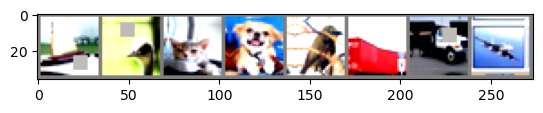

ship  bird  cat   dog  


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:8]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [11]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = CustomResNet().to(device)
summary(model, input_size=(3, 32, 32))

You should consider upgrading via the 'I:\Installs\python.exe -m pip install --upgrade pip' command.


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
       BasicBlock-12          [-1, 128, 16, 16]               0
      CustomBlock-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

In [14]:
def get_lr(optimizer):
    """"
    for tracking how your learning rate is changing throughout training
    """
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [15]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
lrs = []

def train(model, device, train_loader, optimizer, epoch, scheduler, criterion):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    train_losses.append(loss)
    lrs.append(get_lr(optimizer))

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} LR={get_lr(optimizer)} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.79E-02


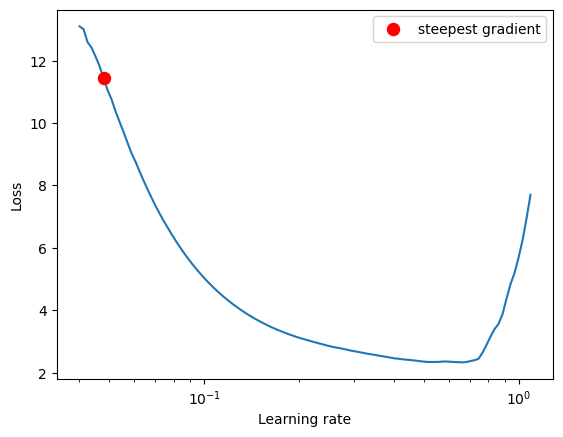

In [16]:
from torch_lr_finder import LRFinder

model = CustomResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [17]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 24

scheduler = OneCycleLR(
        optimizer,
        max_lr=4.79E-02,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, scheduler, criterion)
    test(model, device, test_loader, criterion)

EPOCH: 0


  0%|          | 0/98 [00:00<?, ?it/s]

Loss=1.213370680809021 LR=0.00998259509202454 Batch_id=97 Accuracy=49.21: 100%|██████████| 98/98 [00:22<00:00,  4.45it/s]   



Test set: Average loss: 0.0027, Accuracy: 5612/10000 (56.12%)

EPOCH: 1


Loss=1.051855206489563 LR=0.01948619018404908 Batch_id=97 Accuracy=62.53: 100%|██████████| 98/98 [00:21<00:00,  4.52it/s]  



Test set: Average loss: 0.0020, Accuracy: 6625/10000 (66.25%)

EPOCH: 2


Loss=0.7711672186851501 LR=0.028989785276073616 Batch_id=97 Accuracy=69.70: 100%|██████████| 98/98 [00:21<00:00,  4.58it/s]



Test set: Average loss: 0.0019, Accuracy: 6856/10000 (68.56%)

EPOCH: 3


Loss=0.643369197845459 LR=0.03849338036809816 Batch_id=97 Accuracy=75.36: 100%|██████████| 98/98 [00:21<00:00,  4.52it/s]  



Test set: Average loss: 0.0016, Accuracy: 7357/10000 (73.57%)

EPOCH: 4


Loss=0.7373365163803101 LR=0.04787427754564984 Batch_id=97 Accuracy=76.46: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s] 



Test set: Average loss: 0.0019, Accuracy: 7014/10000 (70.14%)

EPOCH: 5


Loss=0.6279898881912231 LR=0.045353477019334044 Batch_id=97 Accuracy=77.35: 100%|██████████| 98/98 [00:21<00:00,  4.49it/s]



Test set: Average loss: 0.0013, Accuracy: 7721/10000 (77.21%)

EPOCH: 6


Loss=0.5938943028450012 LR=0.04283267649301826 Batch_id=97 Accuracy=78.26: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s] 



Test set: Average loss: 0.0014, Accuracy: 7569/10000 (75.69%)

EPOCH: 7


Loss=0.528529942035675 LR=0.040311875966702465 Batch_id=97 Accuracy=79.15: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s] 



Test set: Average loss: 0.0014, Accuracy: 7476/10000 (74.76%)

EPOCH: 8


Loss=0.5441135764122009 LR=0.03779107544038668 Batch_id=97 Accuracy=79.52: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s] 



Test set: Average loss: 0.0018, Accuracy: 6872/10000 (68.72%)

EPOCH: 9


Loss=0.38936248421669006 LR=0.03527027491407089 Batch_id=97 Accuracy=80.27: 100%|██████████| 98/98 [00:21<00:00,  4.61it/s] 



Test set: Average loss: 0.0013, Accuracy: 7866/10000 (78.66%)

EPOCH: 10


Loss=0.5830236077308655 LR=0.0327494743877551 Batch_id=97 Accuracy=80.72: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s]  



Test set: Average loss: 0.0014, Accuracy: 7614/10000 (76.14%)

EPOCH: 11


Loss=0.5461108088493347 LR=0.03022867386143931 Batch_id=97 Accuracy=81.29: 100%|██████████| 98/98 [00:21<00:00,  4.58it/s]  



Test set: Average loss: 0.0011, Accuracy: 8072/10000 (80.72%)

EPOCH: 12


Loss=0.5670895576477051 LR=0.02770787333512352 Batch_id=97 Accuracy=81.41: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s]  



Test set: Average loss: 0.0012, Accuracy: 8008/10000 (80.08%)

EPOCH: 13


Loss=0.4737085700035095 LR=0.02518707280880773 Batch_id=97 Accuracy=82.19: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s]  



Test set: Average loss: 0.0013, Accuracy: 7785/10000 (77.85%)

EPOCH: 14


Loss=0.5284845232963562 LR=0.02266627228249194 Batch_id=97 Accuracy=82.51: 100%|██████████| 98/98 [00:21<00:00,  4.63it/s]  



Test set: Average loss: 0.0010, Accuracy: 8242/10000 (82.42%)

EPOCH: 15


Loss=0.5897759795188904 LR=0.020145471756176155 Batch_id=97 Accuracy=83.31: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s] 



Test set: Average loss: 0.0011, Accuracy: 8235/10000 (82.35%)

EPOCH: 16


Loss=0.448693186044693 LR=0.01762467122986036 Batch_id=97 Accuracy=83.76: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s]   



Test set: Average loss: 0.0012, Accuracy: 8040/10000 (80.40%)

EPOCH: 17


Loss=0.4228397011756897 LR=0.015103870703544568 Batch_id=97 Accuracy=84.97: 100%|██████████| 98/98 [00:21<00:00,  4.48it/s] 



Test set: Average loss: 0.0009, Accuracy: 8341/10000 (83.41%)

EPOCH: 18


Loss=0.43616312742233276 LR=0.012583070177228782 Batch_id=97 Accuracy=85.91: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s]



Test set: Average loss: 0.0009, Accuracy: 8469/10000 (84.69%)

EPOCH: 19


Loss=0.4017539322376251 LR=0.010062269650912989 Batch_id=97 Accuracy=86.93: 100%|██████████| 98/98 [00:21<00:00,  4.60it/s] 



Test set: Average loss: 0.0011, Accuracy: 8280/10000 (82.80%)

EPOCH: 20


Loss=0.31013476848602295 LR=0.007541469124597203 Batch_id=97 Accuracy=87.81: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s]



Test set: Average loss: 0.0007, Accuracy: 8812/10000 (88.12%)

EPOCH: 21


Loss=0.3023022711277008 LR=0.005020668598281416 Batch_id=97 Accuracy=89.48: 100%|██████████| 98/98 [00:21<00:00,  4.58it/s]  



Test set: Average loss: 0.0006, Accuracy: 8906/10000 (89.06%)

EPOCH: 22


Loss=0.22469988465309143 LR=0.00249986807196563 Batch_id=97 Accuracy=91.44: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s]  



Test set: Average loss: 0.0005, Accuracy: 9073/10000 (90.73%)

EPOCH: 23


Loss=0.181439608335495 LR=-2.0932454350162943e-05 Batch_id=97 Accuracy=93.32: 100%|██████████| 98/98 [00:21<00:00,  4.57it/s] 



Test set: Average loss: 0.0005, Accuracy: 9156/10000 (91.56%)

